<a href="https://colab.research.google.com/github/Mr-Ndi/DarkSkills/blob/main/Multilayer_Perceptron_Week_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an MLP on MNIST with NumPy

## Section1 Train-Validation-Test

###  2.Load and Prepare the Dataset

In [11]:
import numpy as np
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X.values # This returns the array values
y = y.astype(int).values # This returns the array values

#### Preprocessing: Normalize the data


In [2]:
X = ((X / 255.) - .5) * 2

#### Visualize sample digits

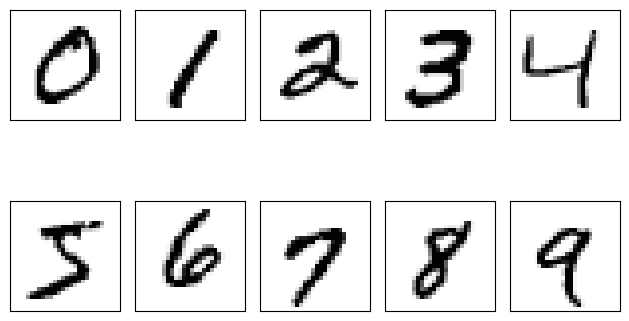

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

###2. Train-Validation-Test Split

In [9]:
from sklearn.model_selection import train_test_split
# Splits:
# - 60k train+valid, 10k test
# - 55k train, 5k valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=5000, random_state=123)

##3. Create Mini-batches

In [10]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

##4. Build Core Components of MLP

###A. Linear Layer (Fully Connected Layer)

In [12]:
# We are going to
  # Initialize weight with small random values
  # Initialize bias with zeros
  # Initialize grad_weight with zeros. Same shape as weight
  # Initialize grad_bias with zeros. Same shape as bias
  # Implement forward()

class Linear:
    def __init__(self, in_features, out_features):
        # Initialize weight to small random values (normally distributed)
        self.weight = np.random.randn(in_features, out_features) * 0.01

        # Initialize bias to zeros
        self.bias = np.zeros((1, out_features))

        # Initialize gradients for weight and bias to zeros
        self.grad_weight = np.zeros_like(self.weight)
        self.grad_bias = np.zeros_like(self.bias)

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        self.input = x  # Keep input for backward pass
        output = np.dot(x, self.weight) + self.bias  # Linear transformation
        return output

    def backward(self, grad_output):
        # Compute the gradient of the input
        grad_input = np.dot(grad_output, self.weight.T)

        # Compute gradients for weight and bias
        self.grad_weight[...] = np.dot(self.input.T, grad_output)  # Weight gradient
        self.grad_bias[...] = np.mean(grad_output, axis=0, keepdims=True)  # Bias gradient

        return grad_input

    def parameters(self):
        """Returns the parameters (weights and bias) of this layer."""
        return [self.weight, self.bias]

    def gradients(self):
        """Returns the gradients (weight and bias gradients) of this layer."""
        return [self.grad_weight, self.grad_bias]


###B. Sigmoid Activation Function

In [13]:
#we are going to Implement the sigmoid function in forward
class Sigmoid:
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        # Compute the sigmoid function
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, grad_output):
        # Use the stored output from the forward pass to compute the gradient
        return grad_output * self.output * (1 - self.output)

###C. Mean Squared Error Loss (MSELoss)

In [14]:
class MSELoss:
    def __call__(self, pred, target):
        return self.forward(pred, target)

    def forward(self, pred, target):
        self.pred = pred  # Save for backward
        self.target = target  # Save for backward
        error = np.mean((pred - target) ** 2)  # Mean squared error
        return error

    def backward(self):
        # Derivative of MSE w.r.t. predictions
        return 2. * (self.pred - self.target) / self.target.shape[0]

##5. Gradient Descent Optimizer


In [15]:
# This SGD class performs parameter updates using gradients computed during backpropagation.
class SGD:
    def __init__(self, params, grads, lr=0.1):
        self.params = params
        self.grads = grads
        self.lr = lr

    def step(self):
        """Update the parameters (weight and bias) of your netork using the Gradient Descent algorithm."""
        for p, g in zip(self.params, self.grads):
            p -= self.lr * g # gradient descent

    def zero_grad(self):
        """Zeros out the gradient of your network"""
        for g in self.grads:
            g.fill(0.0)

##6. Assemble the MLP


In [17]:
# We have an MLP with:

#     Input layer: 784 neurons (28×28)
#     Hidden layer: 50 neurons with Sigmoid activation
#     Output layer: 10 neurons (one per digit) with Sigmoid activation

# What we have todo is:

#     In __init__: Create two linear layers and two activations
#     In forward: Pass input through layers in sequence
#     e.g. x → linear1 → sigmoid → linear2 → sigmoid

class MLP:
    def __init__(self, in_features, hidden_size, out_features):
        # Initialize layers and activations
        self.linear1 = Linear(in_features, hidden_size)
        self.act1 = Sigmoid()
        self.linear2 = Linear(hidden_size, out_features)
        self.act2 = Sigmoid()

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        """Forward propagation through your network"""
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        return x

    def backward(self, grad_output):
        """Backpropagation through your network"""
        grad_z2 = self.act2.backward(grad_output)
        grad_a1 = self.linear2.backward(grad_z2)

        grad_z1 = self.act1.backward(grad_a1)
        _ = self.linear1.backward(grad_z1)

    def parameters(self):
        """Return the parameters of your entire model/network"""
        return self.linear1.parameters() + self.linear2.parameters()

    def gradients(self):
        """Return the gradients of your entire model/network"""
        return self.linear1.gradients() + self.linear2.gradients()


##7. Training and Evaluation


###A. Training Function

In [18]:
# Performs forward and backward passes for each mini-batch
# Updates weights using SGD

def train(model, train_loader, optimizer, criterion):
    total_loss = 0.0
    num_samples = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        preds = model(X_batch)
        loss = criterion(preds, int_to_onehot(y_batch))

        grad_output = loss_fn.backward()

        model.backward(grad_output)
        optimizer.step()

        total_loss += loss
        num_samples += len(y_batch)

    return total_loss / num_samples

###B. Validation Function

In [19]:
# Computes loss and accuracy on the validation set
def valid(model, valid_loader, criterion):
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for X_batch, y_batch in valid_loader:
        preds = model(X_batch)
        loss = criterion(preds, int_to_onehot(y_batch))

        total_loss += loss

        predicted_labels = np.argmax(preds, axis=1)
        correct_predictions += (predicted_labels == y_batch).sum()
        total_predictions += len(y_batch)

    total_loss /= total_predictions
    accuracy = (correct_predictions / total_predictions)*100
    return total_loss, accuracy

###C. Convert Targets

In [20]:
def int_to_onehot(y, num_labels=10):
      return np.eye(num_labels)[y]

##8. Instantiate Model, Loss Function, and Optimizer

In [22]:
# Before training, we must initialize our network and supporting components.
in_features = 28 * 28      # Each image is 28x28 pixels
hidden_size = 50           # Size of the hidden layer (can experiment)
out_features = 10          # One output per digit class (0-9)
learning_rate = 0.1        # Step size for SGD updates

np.random.seed(123)        # For reproducible results

model = MLP(in_features=in_features, hidden_size=hidden_size, out_features=out_features)
loss_fn = MSELoss()
optimizer = SGD(model.parameters(), model.gradients(), lr=learning_rate)

##9. Run the Training Loop


In [27]:
# Now that everything is in place, we can train the MLP using mini-batch SGD:
num_epochs = 5
batch_size = 100

for epoch in range(num_epochs):
    # Usually in the PyTorch way, dataloader SHOULD NOT be in the epoch loop
    train_loader = minibatch_generator(X_train, y_train, minibatch_size=batch_size)
    valid_loader = minibatch_generator(X_valid, y_valid, minibatch_size=batch_size)

    train_loss = train(model, train_loader, optimizer, criterion=loss_fn)
    valid_loss, valid_acc = valid(model, valid_loader, criterion=loss_fn)

    print(f"Epoch: {epoch+1:02d}/{num_epochs} | Train MSE: {train_loss:.4f} | Valid MSE: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")

/tmp/ipython-input-13-766233039.py:8: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-x))


Epoch: 01/5 | Train MSE: 0.0002 | Valid MSE: 0.0002 | Valid Acc: 90.92%
Epoch: 02/5 | Train MSE: 0.0002 | Valid MSE: 0.0001 | Valid Acc: 91.18%
Epoch: 03/5 | Train MSE: 0.0001 | Valid MSE: 0.0001 | Valid Acc: 91.80%
Epoch: 04/5 | Train MSE: 0.0001 | Valid MSE: 0.0001 | Valid Acc: 91.24%
Epoch: 05/5 | Train MSE: 0.0001 | Valid MSE: 0.0001 | Valid Acc: 91.16%


##10. Final Evaluation on Test Set

In [28]:
# We are going to measure final generalization accuracy using:
def test(model, test_loader):
    correct_predictions = 0
    total_predictions = 0
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)

        predicted_labels = np.argmax(preds, axis=1)
        correct_predictions += (predicted_labels == y_batch).sum()
        total_predictions += len(y_batch)

    accuracy = (correct_predictions / total_predictions)*100
    return accuracy


test_loader = minibatch_generator(X_test, y_test, minibatch_size=100)
test_acc = test(model, test_loader)
print(f'Test accuracy: {test_acc:.2f}%')

/tmp/ipython-input-13-766233039.py:8: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-x))


Test accuracy: 90.62%
